# Animation

I copied this notebook from the [repository](https://github.com/hyzhak/matplotlib-experiments/blob/master/animation.ipynb) of Eugene Krevenets.

based on:
- http://matplotlib.org/users/whats_new.html#display-hook-for-animations-in-the-ipython-notebook
- http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

# we don't have avconv
# matplotlib.rcParams['animation.writer'] = 'avconv'

# doesn't work as well - just show blank video player
# matplotlib.rcParams['animation.writer'] = 'imagemagick'

print('animation writers:', matplotlib.animation.writers.list())

animation writers: ['pillow', 'ffmpeg', 'ffmpeg_file', 'html']


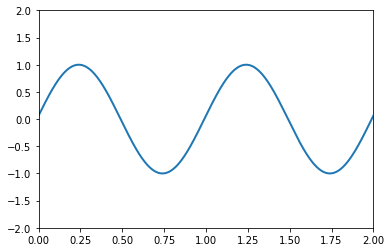

In [3]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( 0, 2))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=30, blit=True)

HTML(anim.to_html5_video())
# TODO: still have problem:
# how to hide extra figure
# if I will use
# fig.set_visible(False)
# it will hide animation as well

http://matplotlib.org/gallery/animation/animate_decay.html

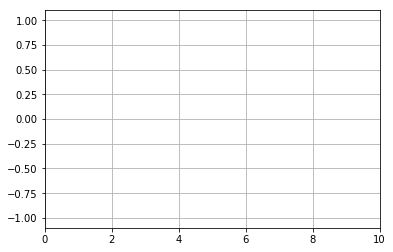

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def data_gen(t=0):
    cnt = 0
    while cnt < 1000:
        cnt += 1
        t += 0.1
        yield t, np.sin(2*np.pi*t) * np.exp(-t/10.)


def init():
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlim(0, 10)
    del xdata[:]
    del ydata[:]
    line.set_data(xdata, ydata)
    return line,

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.grid()
xdata, ydata = [], []


def run(data):
    # update the data
    t, y = data
    xdata.append(t)
    ydata.append(y)
    xmin, xmax = ax.get_xlim()

    if t >= xmax:
        ax.set_xlim(xmin, 2*xmax)
        ax.figure.canvas.draw()
    line.set_data(xdata, ydata)

    return line,

ani = animation.FuncAnimation(fig, run, frames=data_gen, blit=False, interval=10,
                              repeat=False, init_func=init)
#plt.show()
HTML(ani.to_html5_video())

# The Bayes update
- http://matplotlib.org/gallery/animation/bayes_update_sgskip.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html

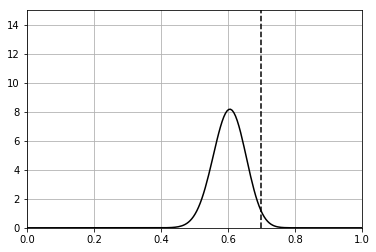

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from matplotlib.animation import FuncAnimation


class UpdateDist(object):
    def __init__(self, ax, prob=0.5):
        self.success = 0
        self.prob = prob
        self.line, = ax.plot([], [], 'k-')
        self.x = np.linspace(0, 1, 200)
        self.ax = ax

        # Set up plot parameters
        self.ax.set_xlim(0, 1)
        self.ax.set_ylim(0, 15)
        self.ax.grid(True)

        # This vertical line represents the theoretical value, to
        # which the plotted distribution should converge.
        self.ax.axvline(prob, linestyle='--', color='black')

    def init(self):
        self.success = 0
        self.line.set_data([], [])
        return self.line,

    def __call__(self, i):
        # This way the plot can continuously run and we just keep
        # watching new realizations of the process
        if i == 0:
            return self.init()

        # Choose success based on exceed a threshold with a uniform pick
        if np.random.rand(1,) < self.prob:
            self.success += 1
        y = ss.beta.pdf(self.x, self.success + 1, (i - self.success) + 1)
        self.line.set_data(self.x, y)
        return self.line,

# Fixing random state for reproducibility
np.random.seed(19680801)


fig, ax = plt.subplots()
ud = UpdateDist(ax, prob=0.7)
anim = FuncAnimation(fig, ud, frames=np.arange(100), init_func=ud.init,
                     interval=100, blit=True)
HTML(anim.to_html5_video())

# The double pendulum problem
- http://matplotlib.org/gallery/animation/double_pendulum_animated_sgskip.html

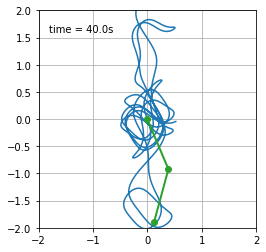

In [6]:
from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation

G = 9.8  # acceleration due to gravity, in m/s^2
L1 = 1.0  # length of pendulum 1 in m
L2 = 1.0  # length of pendulum 2 in m
M1 = 1.0  # mass of pendulum 1 in kg
M2 = 1.0  # mass of pendulum 2 in kg


def derivs(state, t):

    dydx = np.zeros_like(state)
    dydx[0] = state[1]

    del_ = state[2] - state[0]
    den1 = (M1 + M2)*L1 - M2*L1*cos(del_)*cos(del_)
    dydx[1] = (M2*L1*state[1]*state[1]*sin(del_)*cos(del_) +
               M2*G*sin(state[2])*cos(del_) +
               M2*L2*state[3]*state[3]*sin(del_) -
               (M1 + M2)*G*sin(state[0]))/den1

    dydx[2] = state[3]

    den2 = (L2/L1)*den1
    dydx[3] = (-M2*L2*state[3]*state[3]*sin(del_)*cos(del_) +
               (M1 + M2)*G*sin(state[0])*cos(del_) -
               (M1 + M2)*L1*state[1]*state[1]*sin(del_) -
               (M1 + M2)*G*sin(state[2]))/den2

    return dydx

# create a time array from 0..100 sampled at 0.05 second steps
dt = 0.05
t = np.arange(0.0, 40, dt)

# th1 and th2 are the initial angles (degrees)
# w10 and w20 are the initial angular velocities (degrees per second)
th1 = 120.0
w1 = 0.0
th2 = -10.0
w2 = 0.0

# initial state
state = np.radians([th1, w1, th2, w2])

# integrate your ODE using scipy.integrate.
y = integrate.odeint(derivs, state, t)

x1 = L1*sin(y[:, 0])
y1 = -L1*cos(y[:, 0])

x2 = L2*sin(y[:, 2]) + x1
y2 = -L2*cos(y[:, 2]) + y1

fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2))
ax.set_aspect('equal')
ax.grid()

# My small update:
x = np.linspace(-2, 2, len(y))
line_y1, = ax.plot([], [])
line_y2, = ax.plot([], [])

line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)



def init():
    line.set_data([], [])
    # My small update:
    line_y1.set_data([], [])
    line_y2.set_data([], [])
    time_text.set_text('')
    return line, line_y1, line_y2, time_text


def animate(i):
    thisx = [0, x1[i], x2[i]]
    thisy = [0, y1[i], y2[i]]

    line.set_data(thisx, thisy)
    # My small update:
    line_y1.set_data(y[:i, 0] / 4, y[:i, 2] / 4)
#     line_y2.set_data(y[:i, 1] / 4, y[:i, 3] / 4)    
#     line_y1.set_data(x[:i], y2[:i])
#     line_y1.set_data(x[:i], y[:i, 1] / 10)
#     line_y2.set_data(x[:i], y2[:i])
#     line_y2.set_data(x[:i], y[:i, 3] / 10)
    time_text.set_text(time_template % (i*dt))
    return line, line_y1, line_y2, time_text

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(y)),
                              interval=25, blit=True, init_func=init)

# ani.save('double_pendulum.mp4', fps=15)
HTML(ani.to_html5_video())

# An animated image
http://matplotlib.org/gallery/animation/dynamic_image.html

**imshow** is here

number of frame is least common multiple:
$$
\operatorname{lcm}(a,b)=\frac{|a\cdot b|}{\operatorname{gcd}(a,b)}.
$$
gdc - is the greatest common divisor

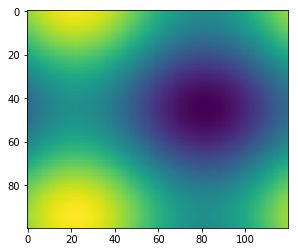

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)

fig = plt.figure()
im = plt.imshow(f(x, y), animated=True)


def updatefig(*args):
    global x, y
    x += np.pi / 15.
    y += np.pi / 20.
    im.set_array(f(x, y))
    return im,

1*2*3*5

# number of frame is least common multiple
ani = animation.FuncAnimation(fig, updatefig, interval=30, frames=range(2*60), blit=True)
HTML(ani.to_html5_video())

# Animated histogram
http://matplotlib.org/gallery/animation/histogram.html

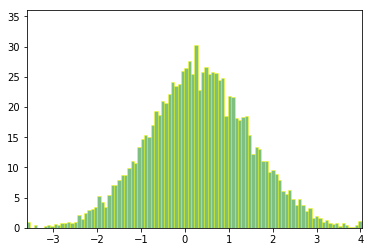

In [8]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import matplotlib.animation as animation

fig, ax = plt.subplots()

# Fixing random state for reproducibility
np.random.seed(19680801)

# histogram our data with numpy
data = np.random.randn(1000)
n, bins = np.histogram(data, 100)

# get the corners of the rectangles for the histogram
left = np.array(bins[:-1])
right = np.array(bins[1:])
bottom = np.zeros(len(left))
top = bottom + n
nrects = len(left)

# here comes the tricky part -- we have to set up the vertex and path
# codes arrays using moveto, lineto and closepoly

# for each rect: 1 for the MOVETO, 3 for the LINETO, 1 for the
# CLOSEPOLY; the vert for the closepoly is ignored but we still need
# it to keep the codes aligned with the vertices
nverts = nrects*(1 + 3 + 1)
verts = np.zeros((nverts, 2))
codes = np.ones(nverts, int) * path.Path.LINETO
codes[0::5] = path.Path.MOVETO
codes[4::5] = path.Path.CLOSEPOLY
verts[0::5, 0] = left
verts[0::5, 1] = bottom
verts[1::5, 0] = left
verts[1::5, 1] = top
verts[2::5, 0] = right
verts[2::5, 1] = top
verts[3::5, 0] = right
verts[3::5, 1] = bottom

barpath = path.Path(verts, codes)
patch = patches.PathPatch(
    barpath, facecolor='green', edgecolor='yellow', alpha=0.5)
ax.add_patch(patch)

ax.set_xlim(left[0], right[-1])
ax.set_ylim(bottom.min(), top.max())


def animate(i):
    # simulate new data coming in
    data = np.random.randn(1000)
    n, bins = np.histogram(data, 100)
    top = bottom + n
    coef = 5
    verts[1::5, 1] += (top - verts[1::5, 1]) / coef
    verts[2::5, 1] += (top - verts[2::5, 1]) / coef
    return [patch, ]

ani = animation.FuncAnimation(fig, animate, 100, interval=25, repeat=True, blit=True)
HTML(ani.to_html5_video())

# Rain simulation
http://matplotlib.org/gallery/animation/rain.html

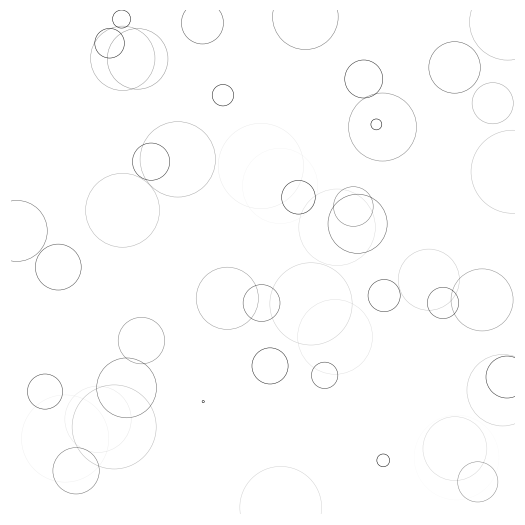

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Fixing random state for reproducibility
np.random.seed(19680801)


# Create new Figure and an Axes which fills it.
fig = plt.figure(figsize=(7, 7))
ax = fig.add_axes([0, 0, 1, 1], frameon=False)
ax.set_xlim(0, 1), ax.set_xticks([])
ax.set_ylim(0, 1), ax.set_yticks([])

# Create rain data
n_drops = 50
rain_drops = np.zeros(n_drops, dtype=[('position', float, 2),
                                      ('size',     float, 1),
                                      ('growth',   float, 1),
                                      ('color',    float, 4)])

# Initialize the raindrops in random positions and with
# random growth rates.
rain_drops['position'] = np.random.uniform(0, 1, (n_drops, 2))
rain_drops['growth'] = np.random.uniform(50, 200, n_drops)

# Construct the scatter which we will update during animation
# as the raindrops develop.
scat = ax.scatter(rain_drops['position'][:, 0], rain_drops['position'][:, 1],
                  s=rain_drops['size'], lw=0.5, edgecolors=rain_drops['color'],
                  facecolors='none')


def update(frame_number):
    # Get an index which we can use to re-spawn the oldest raindrop.
    current_index = frame_number % n_drops

    # Make all colors more transparent as time progresses.
    rain_drops['color'][:, 3] -= 1.0/len(rain_drops)
    rain_drops['color'][:, 3] = np.clip(rain_drops['color'][:, 3], 0, 1)

    # Make all circles bigger.
    rain_drops['size'] += rain_drops['growth']

    # Pick a new position for oldest rain drop, resetting its size,
    # color and growth factor.
    rain_drops['position'][current_index] = np.random.uniform(0, 1, 2)
    rain_drops['size'][current_index] = 5
    rain_drops['color'][current_index] = (0, 0, 0, 1)
    rain_drops['growth'][current_index] = np.random.uniform(50, 200)

    # Update the scatter collection, with the new colors, sizes and positions.
    scat.set_edgecolors(rain_drops['color'])
    scat.set_sizes(rain_drops['size'])
    scat.set_offsets(rain_drops['position'])


# Construct the animation, using the update function as the animation
# director.
animation = FuncAnimation(fig, update, interval=10)

HTML(animation.to_html5_video())

# Random data
http://matplotlib.org/gallery/animation/random_data.html

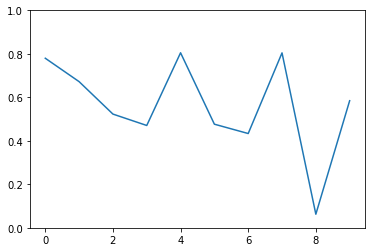

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Fixing random state for reproducibility
np.random.seed(19680801)


fig, ax = plt.subplots()
line, = ax.plot(np.random.rand(10))
ax.set_ylim(0, 1)


def update(data):
    line.set_ydata(data)
    return line,


def data_gen():
    while True:
        yield np.random.rand(10)

ani = animation.FuncAnimation(fig, update, data_gen, interval=100)
HTML(ani.to_html5_video())

# 3D animation
http://matplotlib.org/gallery/animation/simple_3danim.html

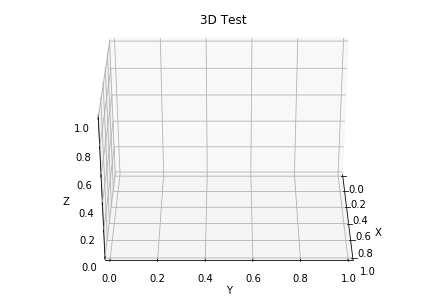

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation

# Fixing random state for reproducibility
np.random.seed(19680801)

frames = 200
worms = 10


def Gen_RandLine(length, dims=2):
    """
    Create a line using a random walk algorithm

    length is the number of points for the line.
    dims is the number of dimensions the line has.
    """
    lineData = np.empty((dims, length))
    lineData[:, 0] = np.random.rand(dims)
    for index in range(1, length):
        # scaling the random numbers by 0.1 so
        # movement is small compared to position.
        # subtraction by 0.5 is to change the range to [-0.5, 0.5]
        # to allow a line to move backwards.
        step = ((np.random.rand(dims) - 0.5) * 0.1)
        lineData[:, index] = lineData[:, index - 1] + step

    return lineData


def update_lines(num, dataLines, lines):
    for line, data in zip(lines, dataLines):
        # NOTE: there is no .set_data() for 3 dim data...
        line.set_data(data[0:2, :num])
        line.set_3d_properties(data[2, :num])
    # ME: add rotation 
    ax.view_init(30, 360 * num / frames)
    return lines

# Attaching 3D axis to the figure
fig = plt.figure()
ax = p3.Axes3D(fig)

# Fifty lines of random 3-D lines
data = [Gen_RandLine(frames, 3) for index in range(worms)]

# Creating fifty line objects.
# NOTE: Can't pass empty arrays into 3d version of plot()
lines = [ax.plot(dat[0, 0:1], dat[1, 0:1], dat[2, 0:1])[0] for dat in data]

# Setting the axes properties
ax.set_xlim3d([0.0, 1.0])
ax.set_xlabel('X')

ax.set_ylim3d([0.0, 1.0])
ax.set_ylabel('Y')

ax.set_zlim3d([0.0, 1.0])
ax.set_zlabel('Z')

ax.set_title('3D Test')

# Creating the Animation object
line_ani = animation.FuncAnimation(fig, update_lines, frames, fargs=(data, lines),
                                   interval=50, blit=False)

HTML(line_ani.to_html5_video())

# MATPLOTLIB UNCHAINED
http://matplotlib.org/gallery/animation/strip_chart_demo.html

Comparative path demonstration of frequency from a fake signal of a pulsar. (mostly known because of the cover for Joy Division’s Unknown Pleasures)

Author: Nicolas P. Rougier

## TODO
- doesn't show black background in a animation

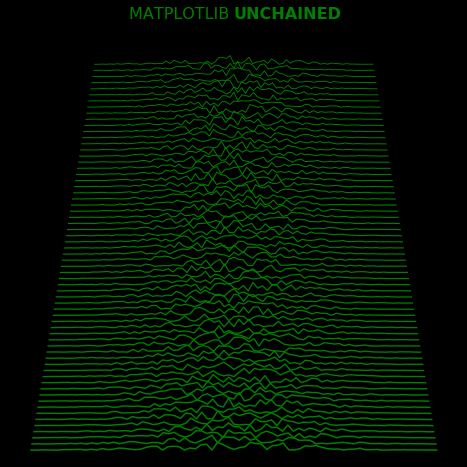

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Fixing random state for reproducibility
np.random.seed(19680801)


# Create new Figure with black background
fig = plt.figure(figsize=(8, 8), facecolor='black')

# Add a subplot with no frame
ax = plt.subplot(111, frameon=False)

# Generate random data
data = np.random.uniform(0, 1, (64, 75))
X = np.linspace(-1, 1, data.shape[-1])
G = 1.5 * np.exp(-4 * X ** 2)

# Generate line plots
lines = []
for i in range(len(data)):
    # Small reduction of the X extents to get a cheap perspective effect
    xscale = 1 - i / 200.
    # Same for linewidth (thicker strokes on bottom)
    lw = 1.5 - i / 100.0
    line, = ax.plot(xscale * X, i + G * data[i], color="green", lw=lw)    
    lines.append(line)

# Set y limit (or first line is cropped because of thickness)
ax.set_ylim(-1, 70)

# No ticks
ax.set_xticks([])
ax.set_yticks([])

# 2 part titles to get different font weights
ax.text(0.5, 1.0, "MATPLOTLIB ", transform=ax.transAxes,
        ha="right", va="bottom", color="green",
        family="sans-serif", fontweight="light", fontsize=16)
ax.text(0.5, 1.0, "UNCHAINED", transform=ax.transAxes,
        ha="left", va="bottom", color="green",
        family="sans-serif", fontweight="bold", fontsize=16)


def update(*args):
    # Shift all data to the right
    data[:, 1:] = data[:, :-1]

    # Fill-in new values
    data[:, 0] = np.random.uniform(0, 1, len(data))

    # Update data
    for i in range(len(data)):
        lines[i].set_ydata(i + G * data[i])

    # Return modified artists
    return lines

# Construct the animation, using the update function as the animation
# director.
anim = animation.FuncAnimation(fig, update, interval=30)
HTML(anim.to_html5_video())
